<a href="https://colab.research.google.com/github/yugonsan/pytorch_practice/blob/main/%E7%AC%AC9%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [3]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [5]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
data_root = './data'

# サンプルの手書き数字データを取得
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,  
    download = True, transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# 対角線上にのみ重みを持つ特殊な畳み込み関数を作る
conv1 = nn.Conv2d(1, 1, 3)

# biasを0に
nn.init.constant_(conv1.bias, 0.0)

# weightを特殊な値に
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1

In [8]:
# 手書き数字に3回畳み込み処理を行う
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

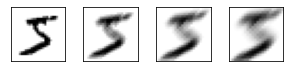

In [9]:
# 結果の画面表示

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

- MNISTとの最大の違いはカラー画像であるという点です
- [3,32,32]という3階テンソルで行われている。初めの要素の3はRGBのこと。
- 奥行きにあたるインデックスのことをチャンネルと呼ぶ
- 初めにカラー画像を1階テンソルで処理してCNNをしてみる
- CNNの特徴は畳み込み処理（Convolution）とプーリング処理（Pooling）です。
- 畳み込み処理はカーネル処理です。
- カーネルは4階テンソルになります
- 4階テンソルのカーネル配列がニューラルネットワークのパラメーターに該当して、このテンソル値が学習の対象になります。
- カーネルが場所を移動しながら学習するために、位置の移動に無関係な特徴量を検出することができます
- プーリング処理（特にmax pooling）は区画で最大値を出力します。
- 縦と横ともに半分の画素数の新しい画像ができることになります
- 物体の大きさによらない普遍的な特徴量を抽出するのに向いている


- 畳み込み処理（nn.Conv2d）
- プーリング処理（nn.MaxPool2d）（内部にパラメタ持たない）
- 1階化関数（flatten）は、チャンネル、タテ、ヨコと3階の広がりを持つ畳み込み関数、プーリング関数の出力が1階テンソルなので、どこかのタイミングでこういう操作が必要になります。


In [10]:
# CNN前半部分　レイヤー関数の定義
conv1 = nn.Conv2d(3, 32, 3) # 入力チャンネル、出力チャンネル、カーネルサイズ
relu = nn.ReLU(inplace=True)  
conv2 = nn.Conv2d(32, 32, 3) 
maxpool = nn.MaxPool2d((2,2)) # 矩形のタテとヨコの画素数

In [11]:
# conv1の確認
print(conv1)
# conv1の内部変数のshape確認
print(conv1.weight.shape) #出力チャンネル、入力チャンネル、カーネルのタテとヨコ
print(conv1.bias.shape)
# conv2の内部変数のshape確認
print(conv2.weight.shape)
print(conv2.bias.shape)
print(conv2.bias.data)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
tensor([ 0.0335, -0.0357, -0.0316, -0.0131,  0.0406,  0.0277, -0.0194, -0.0530,
        -0.0166, -0.0306, -0.0171,  0.0517, -0.0052,  0.0102, -0.0487,  0.0254,
        -0.0574, -0.0547, -0.0458, -0.0369,  0.0056, -0.0285,  0.0176,  0.0176,
         0.0066, -0.0084,  0.0145, -0.0079,  0.0585,  0.0461, -0.0580,  0.0200])


torch.Size([32])は1次元のテンソルで、1列か1行のベクトルを表します。横ベクトルまたは縦ベクトルという言葉は通常、2次元の行列で使われるものですので、このような用語を使って1次元のテンソルの方向を指定することはできません。

In [12]:
# conv1のweight[0]とは、出力チャネル0用の重み
w = conv1.weight[0]

# waeight[0]のshapeと値の確認
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[-0.13184  0.06313 -0.05262]
  [ 0.17935 -0.05261 -0.0424 ]
  [ 0.18795  0.01849 -0.1328 ]]

 [[ 0.15034 -0.02188 -0.06174]
  [ 0.06    -0.08474  0.15893]
  [ 0.0704   0.04945  0.06172]]

 [[ 0.1292   0.07592  0.07167]
  [-0.1541   0.03336  0.05764]
  [-0.12394 -0.18961 -0.1433 ]]]


In [13]:
# ダミーで入力と同じサイズのTensorを生成
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [14]:
# CNNの前半部分をシミュレーション
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [15]:
print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)
# データ件数、チャンネル数、画素数

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [16]:
# nn.Sequentalというクラスに関しては、Pytorchの中でコンテナと呼ばれているクラスの1つ
# 関数定義
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [17]:
# 動作テスト
outputs = features(inputs)

# 結果確認
print(outputs.shape)

torch.Size([100, 32, 14, 14])


In [18]:
# nn.Flatten
# 3階テンソルの形で扱われたデータを、線形関数（nn.Linear）で扱えるよう、1階テンソルの形に変換
# 関数定義
flatten = nn.Flatten()
# 動作テスト
outputs2 = flatten(outputs)
# 結果確認
print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


In [55]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

In [22]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [23]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [24]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


In [25]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [26]:
# Transformsの定義
# transform1 1階テンソル化
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])
# transformer2 正規化のみ実施

# 検証データ用 : 正規化のみ実施
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [27]:
# データ取得用関数 Datasets

data_root = './data'

# 訓練データセット 1階テンソル版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)

# 検証データセット 1階テンソル版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 訓練データセット 3階テンソル版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 検証データセット 3階テンソル版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [28]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [29]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 

In [30]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


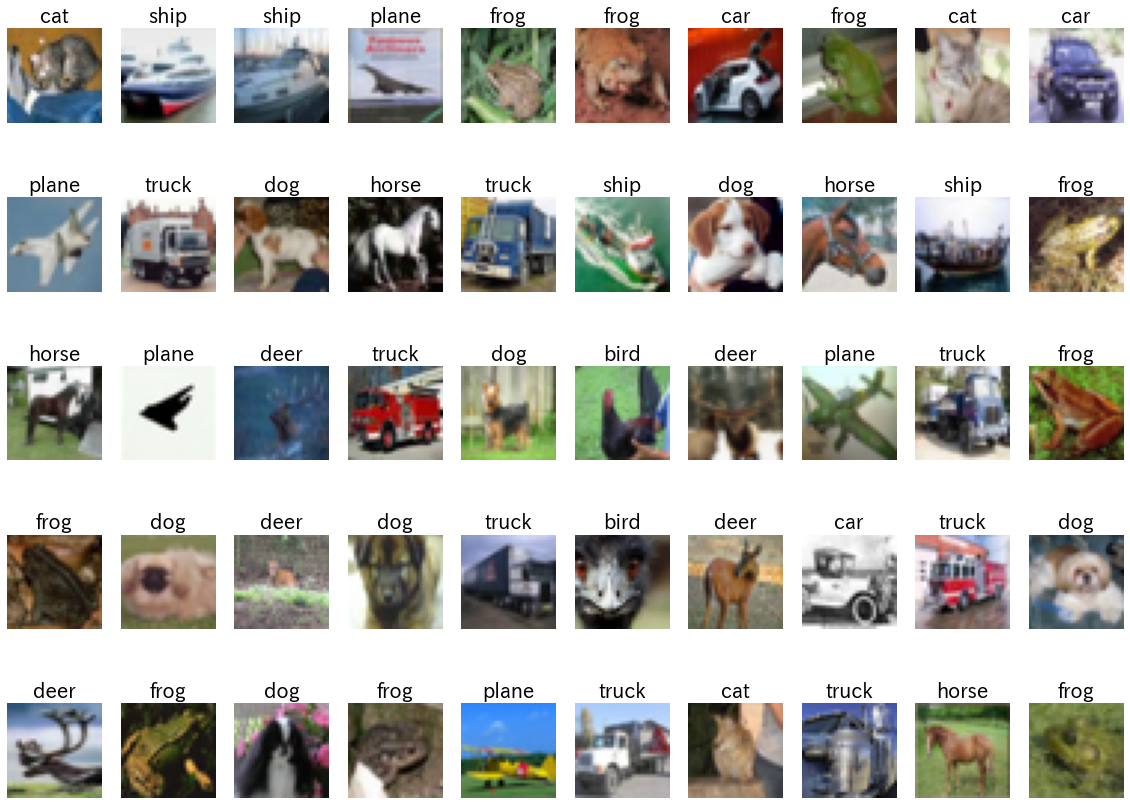

In [31]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

In [39]:
# 入力次元数 今回は3*32*32=3072
n_input = image1.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(classes)

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [40]:
# モデルの定義
# 3072入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [41]:
# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [42]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [43]:
# モデルのサマリー表示

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

In [45]:
# 乱数初期化
torch_seed()
# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)
# 損失関数: 交差エントロピー
criterion = nn.CrossEntropyLoss()
# 学習率
lr = 0.01
# 最適化関数
optimizer = optim.SGD(net.parameters(), lr=lr)
# 繰り返し回数
num_epochs = 50
# 評価記録用
history = np.zeros((0,5))
# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01950 acc: 0.32200 val_loss: 0.01794, val_acc: 0.37670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01738 acc: 0.39572 val_loss: 0.01684, val_acc: 0.41710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01655 acc: 0.42402 val_loss: 0.01622, val_acc: 0.43840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01602 acc: 0.44248 val_loss: 0.01583, val_acc: 0.45120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01563 acc: 0.45530 val_loss: 0.01553, val_acc: 0.46100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01532 acc: 0.46754 val_loss: 0.01530, val_acc: 0.46890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01505 acc: 0.47748 val_loss: 0.01512, val_acc: 0.47340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01480 acc: 0.48604 val_loss: 0.01493, val_acc: 0.47770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01457 acc: 0.49572 val_loss: 0.01480, val_acc: 0.48660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01435 acc: 0.50454 val_loss: 0.01463, val_acc: 0.49010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01413 acc: 0.51112 val_loss: 0.01450, val_acc: 0.49580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01394 acc: 0.52008 val_loss: 0.01437, val_acc: 0.50260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01375 acc: 0.52678 val_loss: 0.01425, val_acc: 0.50590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01357 acc: 0.53504 val_loss: 0.01423, val_acc: 0.50620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.01341 acc: 0.53924 val_loss: 0.01407, val_acc: 0.51360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.01324 acc: 0.54590 val_loss: 0.01402, val_acc: 0.51110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.01307 acc: 0.55108 val_loss: 0.01391, val_acc: 0.51370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01293 acc: 0.55716 val_loss: 0.01388, val_acc: 0.51450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.01278 acc: 0.56146 val_loss: 0.01379, val_acc: 0.51960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01264 acc: 0.56694 val_loss: 0.01380, val_acc: 0.51770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01251 acc: 0.57062 val_loss: 0.01372, val_acc: 0.51810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01237 acc: 0.57726 val_loss: 0.01368, val_acc: 0.52580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01225 acc: 0.58008 val_loss: 0.01363, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.01213 acc: 0.58402 val_loss: 0.01355, val_acc: 0.52440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.01200 acc: 0.59174 val_loss: 0.01352, val_acc: 0.52750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.01189 acc: 0.59382 val_loss: 0.01351, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01177 acc: 0.59886 val_loss: 0.01349, val_acc: 0.52720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.01167 acc: 0.60206 val_loss: 0.01343, val_acc: 0.52960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.01156 acc: 0.60540 val_loss: 0.01342, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01145 acc: 0.60976 val_loss: 0.01346, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01135 acc: 0.61516 val_loss: 0.01341, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.01124 acc: 0.61786 val_loss: 0.01338, val_acc: 0.52870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01114 acc: 0.62116 val_loss: 0.01338, val_acc: 0.53070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.01105 acc: 0.62616 val_loss: 0.01342, val_acc: 0.52810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.01095 acc: 0.62846 val_loss: 0.01341, val_acc: 0.52730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01086 acc: 0.63218 val_loss: 0.01334, val_acc: 0.53210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.01076 acc: 0.63564 val_loss: 0.01340, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.01067 acc: 0.63948 val_loss: 0.01336, val_acc: 0.53080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01059 acc: 0.64206 val_loss: 0.01341, val_acc: 0.53010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.01050 acc: 0.64520 val_loss: 0.01348, val_acc: 0.52430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.01041 acc: 0.64904 val_loss: 0.01340, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01033 acc: 0.65044 val_loss: 0.01347, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.01025 acc: 0.65418 val_loss: 0.01347, val_acc: 0.52500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.01016 acc: 0.65598 val_loss: 0.01346, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.01007 acc: 0.65942 val_loss: 0.01345, val_acc: 0.52630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.01000 acc: 0.66198 val_loss: 0.01344, val_acc: 0.53020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00993 acc: 0.66424 val_loss: 0.01347, val_acc: 0.52600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00984 acc: 0.66810 val_loss: 0.01351, val_acc: 0.52960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00977 acc: 0.67072 val_loss: 0.01363, val_acc: 0.52110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00970 acc: 0.67242 val_loss: 0.01353, val_acc: 0.53100


初期状態: 損失: 0.01794 精度: 0.37670
最終状態: 損失: 0.01353 精度: 0.53100


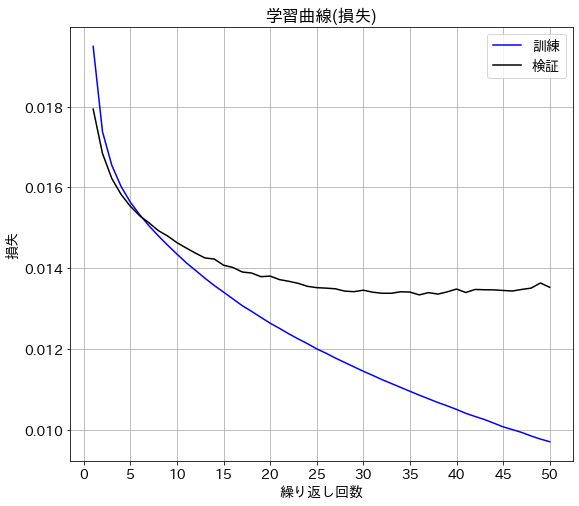

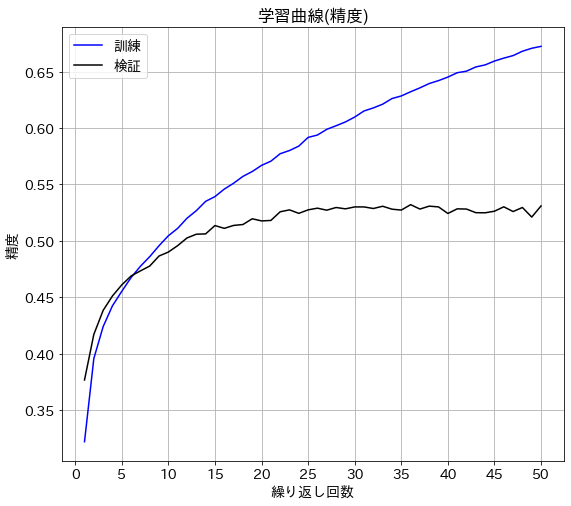

In [46]:
# 評価

evaluate_history(history)

In [59]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3  

In [60]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [61]:
# モデルの表示
print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [62]:
# モデルのサマリー表示
summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [100, 10]                 804,234
Total params: 814,378
Trainable params: 814,378
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

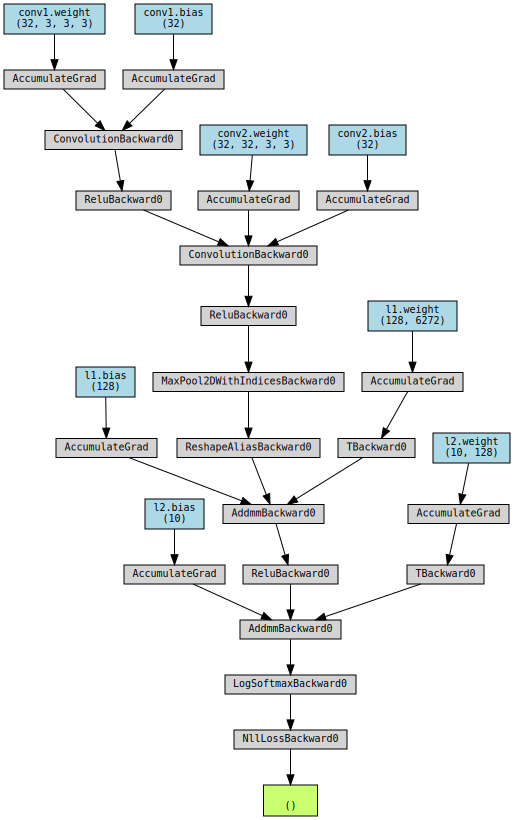

In [63]:
# 損失計算
loss = eval_loss(test_loader2, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [64]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02082 acc: 0.26102 val_loss: 0.01866, val_acc: 0.34640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37300 val_loss: 0.01676, val_acc: 0.40930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43116 val_loss: 0.01529, val_acc: 0.46020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47310 val_loss: 0.01449, val_acc: 0.48880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01408 acc: 0.49962 val_loss: 0.01369, val_acc: 0.51170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01350 acc: 0.52116 val_loss: 0.01332, val_acc: 0.52520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01303 acc: 0.53768 val_loss: 0.01293, val_acc: 0.53860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01253 acc: 0.55442 val_loss: 0.01253, val_acc: 0.55420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01205 acc: 0.57376 val_loss: 0.01237, val_acc: 0.56280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01158 acc: 0.59120 val_loss: 0.01185, val_acc: 0.58040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01117 acc: 0.60786 val_loss: 0.01162, val_acc: 0.58920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01078 acc: 0.62318 val_loss: 0.01169, val_acc: 0.58180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01036 acc: 0.63656 val_loss: 0.01111, val_acc: 0.60830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00998 acc: 0.65142 val_loss: 0.01088, val_acc: 0.61090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00959 acc: 0.66464 val_loss: 0.01115, val_acc: 0.59970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00922 acc: 0.67636 val_loss: 0.01053, val_acc: 0.63210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00882 acc: 0.69250 val_loss: 0.01063, val_acc: 0.62650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00847 acc: 0.70378 val_loss: 0.01013, val_acc: 0.64830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00809 acc: 0.71888 val_loss: 0.01017, val_acc: 0.64240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00774 acc: 0.73136 val_loss: 0.01047, val_acc: 0.63350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00739 acc: 0.74180 val_loss: 0.01000, val_acc: 0.65610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00702 acc: 0.75790 val_loss: 0.01016, val_acc: 0.65470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00674 acc: 0.76592 val_loss: 0.00993, val_acc: 0.65920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00637 acc: 0.77996 val_loss: 0.01001, val_acc: 0.66180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00604 acc: 0.79312 val_loss: 0.00997, val_acc: 0.66880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00569 acc: 0.80542 val_loss: 0.01045, val_acc: 0.64850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00539 acc: 0.81522 val_loss: 0.01052, val_acc: 0.66240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00508 acc: 0.82698 val_loss: 0.01135, val_acc: 0.64120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00474 acc: 0.83954 val_loss: 0.01058, val_acc: 0.66320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00441 acc: 0.85202 val_loss: 0.01103, val_acc: 0.65430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00407 acc: 0.86344 val_loss: 0.01103, val_acc: 0.66480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00380 acc: 0.87372 val_loss: 0.01145, val_acc: 0.65410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00352 acc: 0.88352 val_loss: 0.01142, val_acc: 0.65880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00324 acc: 0.89206 val_loss: 0.01245, val_acc: 0.65120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00295 acc: 0.90422 val_loss: 0.01272, val_acc: 0.64880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00268 acc: 0.91410 val_loss: 0.01293, val_acc: 0.64970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00242 acc: 0.92440 val_loss: 0.01271, val_acc: 0.66170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00217 acc: 0.93274 val_loss: 0.01313, val_acc: 0.66060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00194 acc: 0.94108 val_loss: 0.01344, val_acc: 0.66150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00167 acc: 0.95156 val_loss: 0.01426, val_acc: 0.65520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00148 acc: 0.95836 val_loss: 0.01485, val_acc: 0.65300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00129 acc: 0.96596 val_loss: 0.01541, val_acc: 0.64620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00113 acc: 0.97278 val_loss: 0.01535, val_acc: 0.65790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00093 acc: 0.97904 val_loss: 0.01593, val_acc: 0.65700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00083 acc: 0.98216 val_loss: 0.01636, val_acc: 0.65950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00069 acc: 0.98736 val_loss: 0.01699, val_acc: 0.65350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00047 acc: 0.99436 val_loss: 0.01724, val_acc: 0.66050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00036 acc: 0.99648 val_loss: 0.01775, val_acc: 0.65860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00031 acc: 0.99734 val_loss: 0.01847, val_acc: 0.66250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00025 acc: 0.99848 val_loss: 0.01876, val_acc: 0.65930


初期状態: 損失: 0.01866 精度: 0.34640
最終状態: 損失: 0.01876 精度: 0.65930


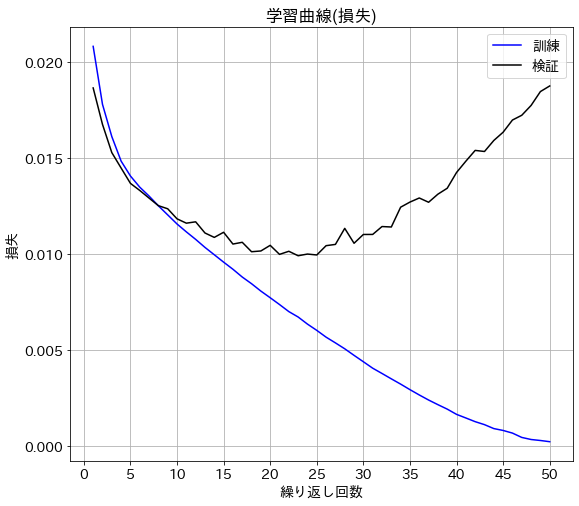

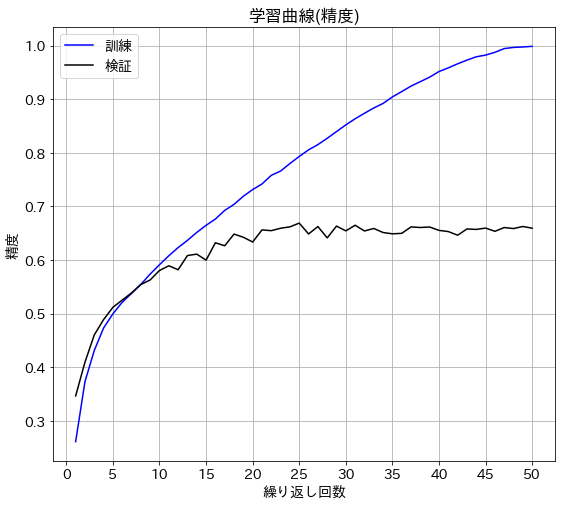

In [65]:
# 評価

evaluate_history(history2)

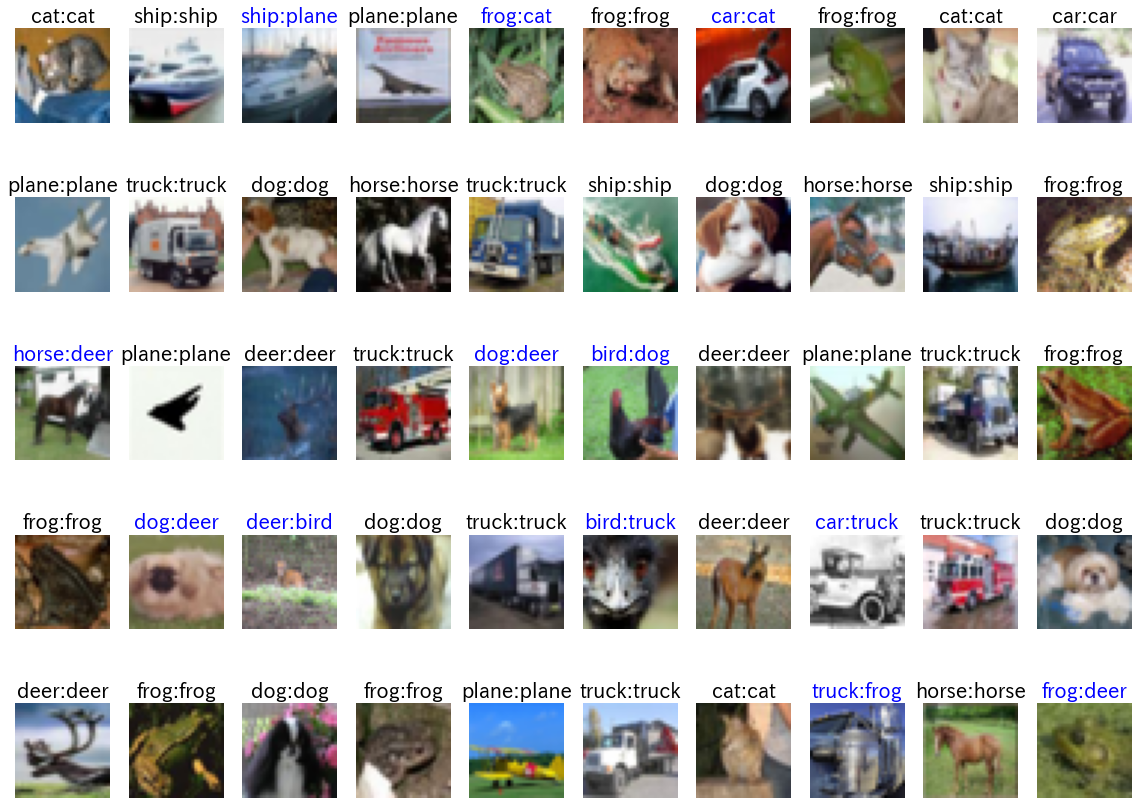

In [66]:
# 最初の50個の表示

show_images_labels(test_loader2, classes, net, device)